In [1]:
# # Requerimientos de librerías:
# !pip install spacy
# !python -m spacy download es_core_news_md

# !pip install transformers
# !pip install transformers scipy ftfy accelerate

# !git clone https://github.com/JorgeSauri/COMSINT.git 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from recomendaciones_comsint import Recomendador

c:\Users\jsaur\anaconda3\envs\ENV1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Con tamaño embeddings 128
- CNN de max 512 kernels (v4)

In [3]:
version = 4

recomendador128 = Recomendador(fuente='recetario_mexicano_small.csv',
                            nutricion = 'nutricion_mejorado.csv',
                            canasta='canasta_basica.csv')

recomendador128.CargarModelo(emb_size=128, version=version)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Modelo Modelos/Modelo_Nut_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.
Modelo Modelos/Modelo_Precios_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.


In [5]:
recomendador128.generar_dataset_entrenamiento_nut(df_nutricionales='nutricion_mejorado.csv', 
                                                  min_ingredientes=5, max_ingredientes=11,
                                                  min_unidades=1, max_unidades=5,
                                                  min_kcal=250, max_kcal= 1500,
                                                  numero_recetas=1
                                                  )

# recomendador128.generar_dataset_entrenamiento_precios(df_precios_profeco='lista_precios_profeco_2022.csv', 
#                                                   numero_recetas=1
#                                                   )                                  

Generando 1  recetas aleatorias...



100%|██████████| 1/1 [00:00<00:00, 334.15it/s]


array([['1 mililitros de pan de avena, 4 mililitros de comida de queso  americano  paquete frío, 2 cucharadas de bacalao crudo, 4 cucharaditas de cordero  asado  cocinado  molido, 2 onzas de mantequilla de maní  sin sal  estilo de trozo, 2 tazas de pavo  asado  cocido  carne y piel  pierna  todas las clases, 4 gramos de yogurt  leche entera  llanura  griega, 2 gramos de carne de res  carne picada  ahumada  curada, 1 gramos de coliflor  con sal  drenado  hervido  cocido  congelado, 4 piezas de jugo de tomate y vegetales  bajo sodio, 1 cucharadas de carne de cerdo  cruda  degada y grasa separable  respaldos  frescos',
        '429.68', '30.82', '16.95', '29.09']], dtype='<U612')

* Entrenar información nutricional

In [4]:
recomendador128.NUM_RECETAS = 5000
recomendador128.EMB_SIZE = 128
ITER = 1
INITIAL_EPOCH = 0
EPOCHS = 50

Rangos_kcal = [
                (200, 1000),
                (300, 1800)           
              ]

Histories = []
for iteracion in range(ITER):
  MINU = 1 
  MAXU = 11  

  for ik in range(len(Rangos_kcal)):
    MINK, MAXK = Rangos_kcal[ik]
    print('\nITERACIÓN:', iteracion+1)
    print('min unidades:',MINU, ' max unidades:', MAXU)
    print('min kcal:', MINK, ' max kcal:', MAXK)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    modelo128, history = recomendador128.EntrenarModelo(df_nutricionales='nutricion_mejorado.csv',
                                  #df_training='recipes_con_info_nutricional.csv',
                                  df_test='recetas_test.csv', 
                                  df_val='recetas_val.csv',
                                  learning_rate=1e-4,
                                  version=version, 
                                  initial_epoch = INITIAL_EPOCH,                             
                                  epochs=INITIAL_EPOCH + EPOCHS, 
                                  kernels=128,                                             
                                  min_ingredientes=5, max_ingredientes=11,
                                  min_unidades=MINU, max_unidades=MAXU,  
                                  min_kcal=MINK, max_kcal= MAXK,                             
                                  save=True, verbose=True)
    INITIAL_EPOCH = history.epoch[-1]

    Histories.append(history)



ITERACIÓN: 1
min unidades: 1  max unidades: 11
min kcal: 350  max kcal: 1500
Entrenando desde epoch 0
------------------------------------------

Error al cargar archivos NumPy.
datasets/numpy/1000_recetas_random_EMBED-128_DATA_X.npy no existe o está corrupto.
datasets/numpy/1000_recetas_random_EMBED-128_DATA_Y.npy no existe o está corrupto.
Generando 1000  recetas aleatorias...



100%|██████████| 1000/1000 [00:09<00:00, 102.10it/s]


Calculando vector de características de 1000 recetas...


100%|██████████| 1000/1000 [03:34<00:00,  4.67it/s]


datasets/numpy/9_TEST_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/9_TEST_EMBED-128_DATA_Y.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_Y.npy cargado con éxito.
Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization (BatchN  (None, 128, 768)         3072      
 ormalization)                                                   
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 P

KeyboardInterrupt: 

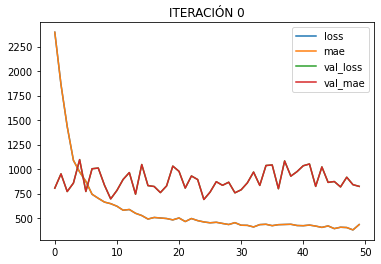

LOSS: 434.7710876464844  -- MAE: 434.7710876464844  -- VAL_LOSS: 824.2960815429688  -- VAL_MAE: 824.2960815429688
----------------------------------------------------------


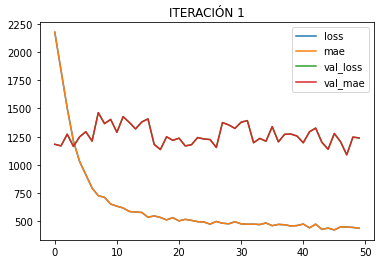

LOSS: 437.0385437011719  -- MAE: 437.0385437011719  -- VAL_LOSS: 1238.53515625  -- VAL_MAE: 1238.53515625
----------------------------------------------------------


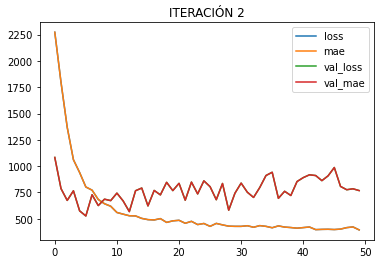

LOSS: 394.4997253417969  -- MAE: 394.4997253417969  -- VAL_LOSS: 768.1340942382812  -- VAL_MAE: 768.1340942382812
----------------------------------------------------------


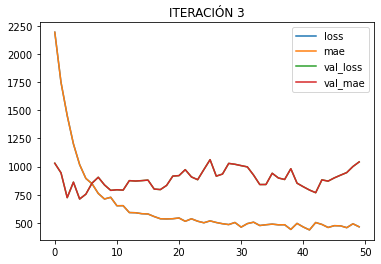

LOSS: 464.87261962890625  -- MAE: 464.87261962890625  -- VAL_LOSS: 1040.8770751953125  -- VAL_MAE: 1040.8770751953125
----------------------------------------------------------


In [7]:
for i in range(len(Histories)):
    history = Histories[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')

* Entrenar precios


ITERACIÓN: 1
Entrenando desde epoch 50
------------------------------------------

Generando 500  recetas aleatorias...



100%|██████████| 500/500 [00:00<00:00, 593.30it/s]


Calculando vector de características de 500 recetas...


100%|██████████| 500/500 [22:40<00:00,  2.72s/it]


Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_4 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 POOLING_1 (MaxPooling1D)    (None, 123, 512)          0         
                                                                 
 CONV_2 (Conv1D)             (None, 121, 256)          393472    
                                                  

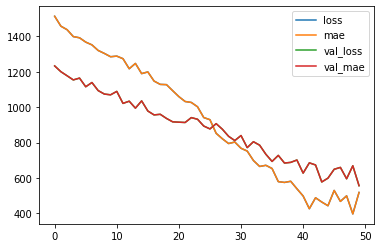

4/4 [==============================] - 1s 106ms/step - loss: 332.3848 - mae: 332.3848
[332.384765625, 332.384765625]
4/4 [==============================] - 1s 91ms/step
receta 0 precio_prom_por_gramo_true: 79.7 precio_prom_por_gramo_pred: 153.71996  precisión: 51.8 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 655.5 precio_prom_por_gramo_pred: 640.2631  precisión: 97.7 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 559.5 precio_prom_por_gramo_pred: 759.6573  precisión: 73.7 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 708.5 precio_prom_por_gramo_pred: 800.56586  precisión: 88.5 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 376.2 precio_prom_por_gramo_pred: 387.72946  precisión: 97.0 %
------------------------------

100%|██████████| 500/500 [00:00<00:00, 515.25it/s]


Calculando vector de características de 500 recetas...


100%|██████████| 500/500 [22:20<00:00,  2.68s/it]


Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 POOLING_1 (MaxPooling1D)    (None, 123, 512)          0         
                                                                 
 CONV_2 (Conv1D)             (None, 121, 256)          393472    
                                                  

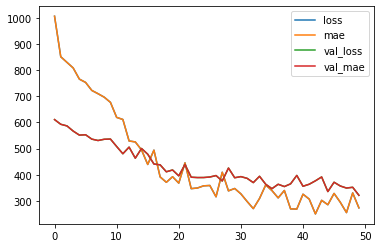

4/4 [==============================] - 1s 92ms/step - loss: 895.9101 - mae: 895.9101
[895.9100952148438, 895.9100952148438]
4/4 [==============================] - 1s 92ms/step
receta 0 precio_prom_por_gramo_true: 219.6 precio_prom_por_gramo_pred: 396.57687  precisión: 55.4 %
---------------------------------------------------------------------------
receta 1 precio_prom_por_gramo_true: 239.2 precio_prom_por_gramo_pred: 274.7464  precisión: 87.1 %
---------------------------------------------------------------------------
receta 2 precio_prom_por_gramo_true: 115.75 precio_prom_por_gramo_pred: 168.75426  precisión: 68.6 %
---------------------------------------------------------------------------
receta 3 precio_prom_por_gramo_true: 1110.0 precio_prom_por_gramo_pred: 1254.7582  precisión: 88.5 %
---------------------------------------------------------------------------
receta 4 precio_prom_por_gramo_true: 301.0 precio_prom_por_gramo_pred: 328.81342  precisión: 91.5 %
-------------------

In [8]:
recomendador128.NUM_RECETAS = 500
recomendador128.EMB_SIZE = 128
ITER = 2
INITIAL_EPOCH = 50
EPOCHS = 50


Histories_precios = []
for iteracion in range(ITER):
    print('\nITERACIÓN:', iteracion+1)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    modelo128_precios, history_precios = recomendador128.EntrenarModeloPrecios(
                                    df_precios='lista_precios_profeco_2022.csv',                                   
                                    learning_rate=1e-3,
                                    version=version, 
                                    initial_epoch = INITIAL_EPOCH,                             
                                    epochs=INITIAL_EPOCH + EPOCHS, 
                                    kernels=128,                                                                         
                                    save=True, verbose=True)
    INITIAL_EPOCH = history_precios.epoch[-1]

    Histories_precios.append(history_precios)

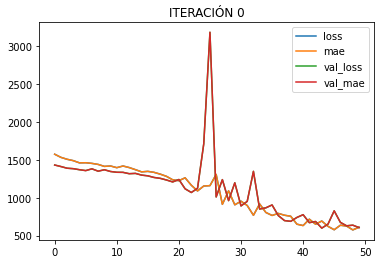

LOSS: 610.884521484375  -- MAE: 610.884521484375  -- VAL_LOSS: 605.876708984375  -- VAL_MAE: 605.876708984375
----------------------------------------------------------


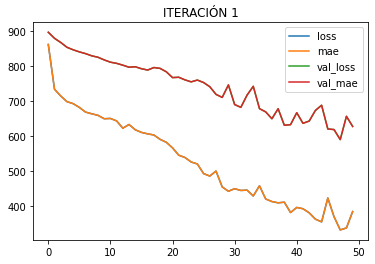

LOSS: 384.781494140625  -- MAE: 384.781494140625  -- VAL_LOSS: 627.9765014648438  -- VAL_MAE: 627.9765014648438
----------------------------------------------------------


In [10]:
for i in range(len(Histories_precios)):
    history = Histories_precios[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')